# MISFAT Data Analysis and Prediction

Ce notebook contient l'analyse et la prédiction des données MISFAT avec:
- Lecture et nettoyage des données CSV
- Visualisation des données
- Modèles de prévision (journalier, hebdomadaire, et mensuel)
- Détection d'anomalies

In [1]:
# === Auto-generated data load & fix cell ===
import pandas as pd, numpy as np, os, re
from datetime import datetime

def preprocess_csv_value(value):
    """Clean CSV numeric value to float."""
    if isinstance(value, str):
        value = value.replace('kWh', '')
        if value.startswith('"') and ';' in value and value.endswith('"'):
            value = value.strip('"').replace(';', '.')
        value = value.replace(',', '.')
        try:
            return float(value)
        except ValueError:
            return 0.0
    return value

file_path = 'MISFAT(3) (1).csv'
assert os.path.exists(file_path), f"Data file {file_path} not found!"

# Load CSV with correct separator/encoding
_df = pd.read_csv(file_path, sep=';', encoding='utf-8')

# Fix timestamp
if 'Timestamp' in _df.columns:
    _df['Timestamp'] = pd.to_datetime(_df['Timestamp'].str.replace(' CEST', ''), errors='coerce')
    _df = _df.dropna(subset=['Timestamp'])
    _df.set_index('Timestamp', inplace=True)

# Drop empty column
if 'Unnamed: 13' in _df.columns:
    _df = _df.drop(columns=['Unnamed: 13'])

# Clean numeric data
for _col in _df.columns:
    _df[_col] = _df[_col].apply(preprocess_csv_value)

# Interpolate missing values
_df = _df.interpolate(method='linear')

# Determine a valid column for analysis
_non_zero_cols = [c for c in _df.columns if _df[c].sum() != 0]
selected_column = _non_zero_cols[0] if _non_zero_cols else _df.columns[0]
print('Selected column for analysis:', selected_column)

# Expose df to notebook namespace
globals()['df'] = _df
globals()['df_running'] = _df.copy()
# === End auto cell ===

Selected column for analysis: G19 KWh-Dif


In [2]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import locale
import re

# Pour les modèles de prédiction
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Email
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Ignorer les avertissements
warnings.filterwarnings('ignore')

# Configuration d'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Fonctions utilitaires - Email

In [3]:
def envoyer_mail_arret_machine(machine_name, start_time, hours_stopped, sender_email, sender_password, receiver_email):
    """
    Envoie un email pour signaler qu'une machine est arrêtée depuis X heures.
    """
    subject = f"⚠️ Machine {machine_name} arrêtée depuis {hours_stopped}h"
    logo_url = "https://misfat.com.tn/wp-content/uploads/2020/10/misfsat-filtration-logo_1.png"
    
    html_body = f"""
    <html>
    <body style="font-family: Arial, sans-serif; background-color: #f4f6f8; padding: 20px;">
        <div style="background-color: white; padding: 30px; border-radius: 12px; max-width: 700px; margin: auto; border: 1px solid #ddd;">
            <div style="text-align: center;">
                <img src="{logo_url}" alt="Logo MISFAT" style="width: 200px;"/>
                <h2 style="color: #e60000;">⚠️ Alerte Machine Arrêtée</h2>
            </div>
            <p style="font-size: 16px; color: #333;">
                Bonjour,<br><br>
                La machine <strong>{machine_name}</strong> est arrêtée depuis <strong>{hours_stopped} heures</strong>.<br><br>
                <strong>Début de l'arrêt :</strong> {start_time.strftime('%d/%m/%Y %H:%M')}<br><br>
                Merci de vérifier rapidement.<br><br>
                <em>(Ceci est un message automatique)</em>
            </p>
            <p style="color: #555; font-size: 12px; text-align: center;">
                © 2025 MISFAT Filtration
            </p>
        </div>
    </body>
    </html>
    """

    msg = MIMEMultipart("alternative")
    msg["From"] = sender_email
    msg["To"] = receiver_email
    msg["Subject"] = subject
    msg.attach(MIMEText(html_body, "html"))

    try:
        # Note: For Gmail, use app password instead of regular password
        # Enable 2FA and generate app password at https://myaccount.google.com/apppasswords
        with smtplib.SMTP("smtp.gmail.com", 587) as server:
            server.starttls()
            server.login(sender_email, sender_password)
            server.send_message(msg)
            print(f"✓ Email envoyé pour {machine_name} arrêtée depuis {hours_stopped}h.")
    except Exception as e:
        print(f"✗ Erreur lors de l'envoi : {e}")

In [4]:
def send_alert_email(anomalies, model_name, sender_email, receiver_email, password):
    """
    Envoie un email d'alerte formaté proprement avec logo, tableau d'anomalies, et modèle utilisé.
    """
    subject = f"⚠️ Alerte : Anomalies détectées - {model_name}"

    # Nettoyage
    anomalies_display = anomalies.copy()
    anomalies_display.columns = [col.lower() for col in anomalies_display.columns]  # tout en minuscule

    # Déterminer les colonnes à afficher
    expected_cols = ['machine', 'date']
    if 'consommation' in anomalies_display.columns:
        expected_cols.append('consommation')
    elif 'valeur' in anomalies_display.columns:
        expected_cols.append('valeur')
    
    anomalies_display = anomalies_display[expected_cols]

    # Convertir anomalies en tableau HTML
    table_html = anomalies_display.to_html(index=False, justify='center', border=1)

    # Logo Misfat
    logo_url = "https://misfat.com.tn/wp-content/uploads/2020/10/misfsat-filtration-logo_1.png"

    # Corps HTML du mail
    body = f"""
    <html>
        <body style="font-family: Arial, sans-serif; background-color: #f4f6f8; padding: 20px;">
            <div style="background-color: white; padding: 30px; border-radius: 12px; border: 1px solid #ddd; max-width: 800px; margin: auto;">
                <div style="text-align: center; margin-bottom: 30px;">
                    <img src="{logo_url}" alt="Logo MISFAT" style="width: 200px;"/>
                    <h2 style="color: #e60000;">⚠️ Alerte : Anomalies Détectées</h2>
                </div>
                <p style="font-size: 16px; color: #333;">
                    Bonjour,<br><br>
                    Nous avons détecté des anomalies dans les données de consommation. 
                    Merci de bien vouloir <strong>vérifier rapidement</strong> les équipements concernés ci-dessous.
                </p>
                <br>
                <p style="font-size: 16px;"><strong>Modèle utilisé :</strong> {model_name}</p>
                <p style="font-size: 16px;"><strong>Détails des anomalies :</strong></p>
                {table_html}
                <br><br>
                <p style="color: #555; font-size: 12px; text-align: center;">
                    Merci de votre réactivité.<br>
                    © 2025 MISFAT Filtration - Tous droits réservés
                </p>
            </div>
        </body>
    </html>
    """

    # Création du message email
    msg = MIMEMultipart("alternative")
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'html'))

    try:
        # Note: For Gmail, use app password instead of regular password
        # Enable 2FA and generate app password at https://myaccount.google.com/apppasswords
        with smtplib.SMTP("smtp.gmail.com", 587) as server:
            server.starttls()
            server.login(sender_email, password)
            server.send_message(msg)
            print("✓ Email d'alerte envoyé avec succès.")
    except Exception as e:
        print(f"✗ Erreur lors de l'envoi de l'email : {e}")

## 2. Lecture et nettoyage des données

In [5]:
def preprocess_csv_value(value):
    """
    Fonction pour nettoyer les valeurs du fichier CSV.
    Gère les différents formats présents dans le fichier.
    """
    if isinstance(value, str):
        # Enlever l'unité 'kWh'
        value = value.replace('kWh', '')
        
        # Si valeur entre guillemets avec point-virgule
        if ';' in value and value.startswith('"') and value.endswith('"'):
            value = value.strip('"').replace(';', '.')
        # Si valeur avec virgule comme décimale
        elif ',' in value:
            value = value.replace(',', '.')
            
        try:
            return float(value)
        except ValueError:
            return 0.0  # Valeur par défaut en cas d'erreur
    return value

def read_misfat_csv(file_path):
    """
    Lecture du fichier CSV avec des options spécifiques pour traiter les formats particuliers.
    """
    try:
        # Lire le fichier avec séparateur point-virgule
        df = pd.read_csv(file_path, sep=';', decimal=',', encoding='utf-8')
        
        # Convertir la colonne timestamp en datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S %Z', errors='coerce')
        
        # Traiter toutes les colonnes numériques
        for col in df.columns:
            if col != 'Timestamp':
                df[col] = df[col].apply(preprocess_csv_value)
        
        # Définir Timestamp comme index
        df.set_index('Timestamp', inplace=True)
        
        print(f"✓ Données chargées avec succès: {df.shape[0]} lignes et {df.shape[1]} colonnes")
        return df
    
    except Exception as e:
        print(f"✗ Erreur lors de la lecture du fichier: {e}")
        return None

In [6]:
# Chargement des données
file_path = 'MISFAT(3) (1).csv'
# Data already preloaded in auto cell; reuse existing df
print('Using preloaded df with shape', df.shape)

# Affichage des premières lignes
print("\nAperçu des données:")
display(df.head())

# Informations sur le dataframe
print("\nInformations sur le dataframe:")
df.info()

# Statistiques descriptives
print("\nStatistiques descriptives:")
display(df.describe())

Using preloaded df with shape (2667, 12)

Aperçu des données:


,G19 KWh-Dif,G26 kWh-Diff,MISFAT 3 D18 KWh-Diff,MISFAT 3 D02.01 M43 KWh-Dif,MISFAT 3 Eclairage 3-2 KWh-Dif,MISFAT 3 G10 KWh-Diff,MISFAT 3 G33 kWh-Diff,MISFAT 3 G39 KWh-Diff,MISFAT 3 H39 KWh-Diff,MISFAT 3 H46 KWh-Diff,MISFAT 3 H53 KWh-Dif,MISFAT 3 N11 KWh-Dif
Timestamp,,,,,,,,,,,,
2025-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Informations sur le dataframe:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2025-01-01 00:00:00 to 2025-04-22 12:00:00
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   G19 KWh-Dif                     2667 non-null   float64
 1   G26 kWh-Diff                    2667 non-null   float64
 2   MISFAT 3 D18 KWh-Diff           2667 non-null   float64
 3   MISFAT 3 D02.01 M43 KWh-Dif     2667 non-null   float64
 4   MISFAT 3 Eclairage 3-2 KWh-Dif  2667 non-null   float64
 5   MISFAT 3 G10 KWh-Diff           2667 non-null   float64
 6   MISFAT 3 G33  kWh-Diff          2667 non-null   float64
 7   MISFAT 3 G39 KWh-Diff           2667 non-null   float64
 8   MISFAT 3 H39 KWh-Diff           2667 non-null   float64
 9   MISFAT 3 H46 KWh-Diff           2667 non-null   float64
 10  MISFAT 3 H53 KWh-Dif            2667 non-null   float64
 11  MISFAT 3 N11 KWh-Dif       

,G19 KWh-Dif,G26 kWh-Diff,MISFAT 3 D18 KWh-Diff,MISFAT 3 D02.01 M43 KWh-Dif,MISFAT 3 Eclairage 3-2 KWh-Dif,MISFAT 3 G10 KWh-Diff,MISFAT 3 G33 kWh-Diff,MISFAT 3 G39 KWh-Diff,MISFAT 3 H39 KWh-Diff,MISFAT 3 H46 KWh-Diff,MISFAT 3 H53 KWh-Dif,MISFAT 3 N11 KWh-Dif
count,2667.000000,2667.000000,2667.000000,2667.000000,2667.0,2667.000000,2667.000000,2667.000000,2667.0,2667.000000,2667.000000,2667.000000
mean,1.007124,7.812523,1.281965,0.075741,0.0,0.004124,0.097488,0.552681,0.0,0.025497,0.020247,0.070491
std,9.242358,24.287400,6.422425,1.227758,0.0,0.213001,2.239475,4.623456,0.0,0.543069,0.473176,0.855402
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,112.000000,107.000000,46.000000,24.000000,0.0,11.000000,59.000000,43.000000,0.0,14.000000,13.000000,13.000000


In [7]:
# Vérification des valeurs manquantes
print("Valeurs manquantes par colonne:")
print(df.isna().sum())

# Traitement des valeurs manquantes (interpolation)
df = df.interpolate(method='time')

# Vérification après traitement
print("\nValeurs manquantes après traitement:")
print(df.isna().sum())

Valeurs manquantes par colonne:
G19 KWh-Dif                       0
G26 kWh-Diff                      0
MISFAT 3 D18 KWh-Diff             0
MISFAT 3 D02.01 M43 KWh-Dif       0
MISFAT 3 Eclairage 3-2 KWh-Dif    0
MISFAT 3 G10 KWh-Diff             0
MISFAT 3 G33  kWh-Diff            0
MISFAT 3 G39 KWh-Diff             0
MISFAT 3 H39 KWh-Diff             0
MISFAT 3 H46 KWh-Diff             0
MISFAT 3 H53 KWh-Dif              0
MISFAT 3 N11 KWh-Dif              0
dtype: int64

Valeurs manquantes après traitement:
G19 KWh-Dif                       0
G26 kWh-Diff                      0
MISFAT 3 D18 KWh-Diff             0
MISFAT 3 D02.01 M43 KWh-Dif       0
MISFAT 3 Eclairage 3-2 KWh-Dif    0
MISFAT 3 G10 KWh-Diff             0
MISFAT 3 G33  kWh-Diff            0
MISFAT 3 G39 KWh-Diff             0
MISFAT 3 H39 KWh-Diff             0
MISFAT 3 H46 KWh-Diff             0
MISFAT 3 H53 KWh-Dif              0
MISFAT 3 N11 KWh-Dif              0
dtype: int64


## 3. Analyse des données et préparation pour la prédiction

In [8]:
# Identification des colonnes avec uniquement des zéros (capteurs inactifs)
mask_machines_off = (df.iloc[:, :] == 0.0).all(axis=1)
df_running = df[~mask_machines_off].copy()  # Machines en marche (important pour l'entraînement)

print(f"Nombre total de lignes : {df.shape[0]}")
print(f"Nombre de lignes avec machines allumées : {df_running.shape[0]}")
print(f"Nombre de lignes ignorées (machines arrêtées) : {mask_machines_off.sum()}")

Nombre total de lignes : 2667
Nombre de lignes avec machines allumées : 547
Nombre de lignes ignorées (machines arrêtées) : 2120


In [9]:
# Recherche des colonnes qui sont totalement à zéro
cols_all_zero = df_running.apply(lambda col: (col == 0.0).all(), axis=0)
cols_all_zero = cols_all_zero[cols_all_zero].index.tolist()

print(f"Colonnes totalement à zéro : {cols_all_zero}")

# Suppression des colonnes inactives
if cols_all_zero:
    df_running = df_running.drop(columns=cols_all_zero)
    print(f"Colonnes supprimées : {cols_all_zero}")
else:
    print("Aucune colonne totalement à zéro. Rien à supprimer.")

Colonnes totalement à zéro : ['MISFAT 3 Eclairage 3-2 KWh-Dif', 'MISFAT 3 H39 KWh-Diff']
Colonnes supprimées : ['MISFAT 3 Eclairage 3-2 KWh-Dif', 'MISFAT 3 H39 KWh-Diff']


In [10]:
# Création de variables temporelles pour l'analyse de série temporelle
df_time = df_running.copy()
df_time['hour'] = df_time.index.hour
df_time['day'] = df_time.index.day
df_time['weekday'] = df_time.index.weekday
df_time['week'] = df_time.index.isocalendar().week
df_time['month'] = df_time.index.month

print("Variables temporelles ajoutées au dataframe")
display(df_time.head())

Variables temporelles ajoutées au dataframe


,G19 KWh-Dif,G26 kWh-Diff,MISFAT 3 D18 KWh-Diff,MISFAT 3 D02.01 M43 KWh-Dif,MISFAT 3 G10 KWh-Diff,MISFAT 3 G33 kWh-Diff,MISFAT 3 G39 KWh-Diff,MISFAT 3 H46 KWh-Diff,MISFAT 3 H53 KWh-Dif,MISFAT 3 N11 KWh-Dif,hour,day,weekday,week,month
Timestamp,,,,,,,,,,,,,,,
2025-01-02 04:00:00,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2,3,1,1
2025-01-02 05:00:00,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2,3,1,1
2025-01-02 07:00:00,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2,3,1,1
2025-01-02 15:00:00,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,2,3,1,1
2025-01-02 19:00:00,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,2,3,1,1


## 4. Visualisation de la consommation par période

In [11]:
def plot_time_series(df, column, title=None):
    """Visualise une série temporelle."""
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df[column], linestyle='-', linewidth=1)
    plt.title(title or f'Série temporelle : {column}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Consommation (kWh)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_daily_pattern(df, column):
    """Visualise le modèle de consommation journalière."""
    daily_avg = df.groupby(df.index.hour)[column].mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(daily_avg.index, daily_avg.values, 'o-', linewidth=2)
    plt.title(f'Modèle de consommation journalière - {column}', fontsize=14)
    plt.xlabel('Heure de la journée', fontsize=12)
    plt.ylabel('Consommation moyenne (kWh)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

def plot_weekly_pattern(df, column):
    """Visualise le modèle de consommation hebdomadaire."""
    weekly_avg = df.groupby(df.index.weekday)[column].mean()
    days = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    
    plt.figure(figsize=(12, 6))
    plt.bar(days, weekly_avg.values, color='skyblue', edgecolor='blue')
    plt.title(f'Modèle de consommation hebdomadaire - {column}', fontsize=14)
    plt.xlabel('Jour de la semaine', fontsize=12)
    plt.ylabel('Consommation moyenne (kWh)', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def plot_monthly_pattern(df, column):
    """Visualise le modèle de consommation mensuelle."""
    # S'il y a suffisamment de données pour couvrir plusieurs mois
    if len(df.index.month.unique()) > 1:
        monthly_avg = df.groupby(df.index.month)[column].mean()
        months = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 
                  'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
        
        # Filtre pour garder seulement les mois disponibles
        available_months = monthly_avg.index.tolist()
        month_labels = [months[i-1] for i in available_months]
        
        plt.figure(figsize=(12, 6))
        plt.bar(month_labels, monthly_avg.values, color='lightgreen', edgecolor='green')
        plt.title(f'Modèle de consommation mensuelle - {column}', fontsize=14)
        plt.xlabel('Mois', fontsize=12)
        plt.ylabel('Consommation moyenne (kWh)', fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print("Pas assez de données pour afficher un modèle mensuel (un seul mois disponible)")

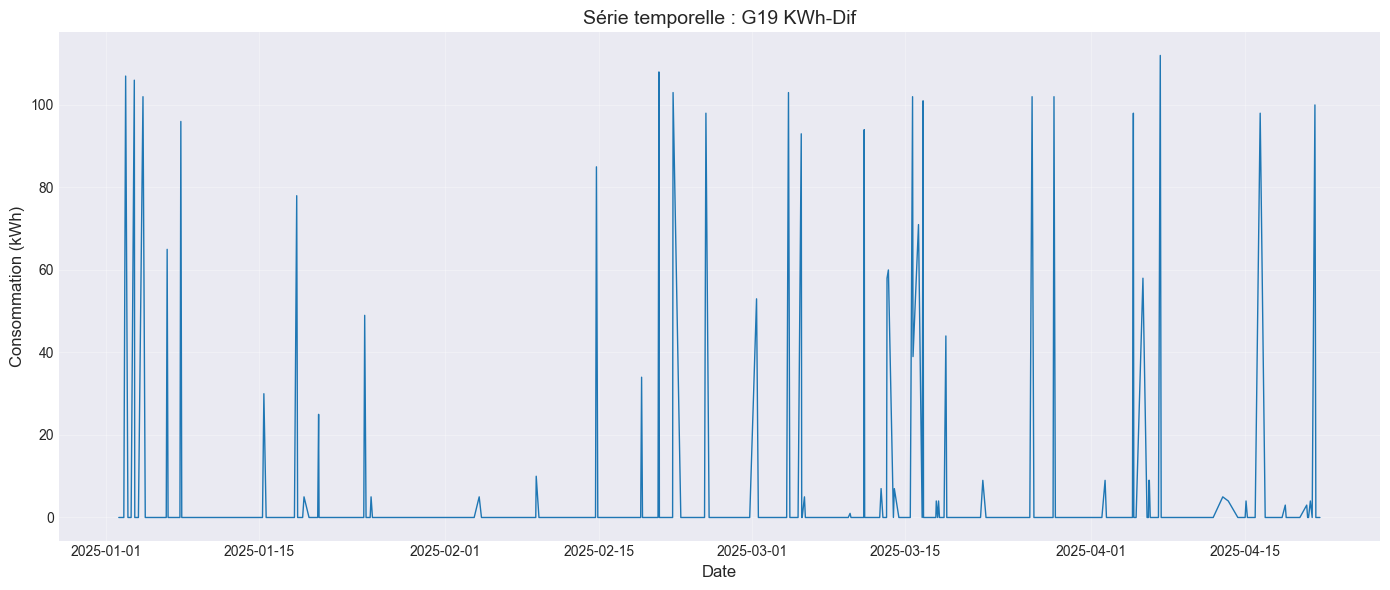

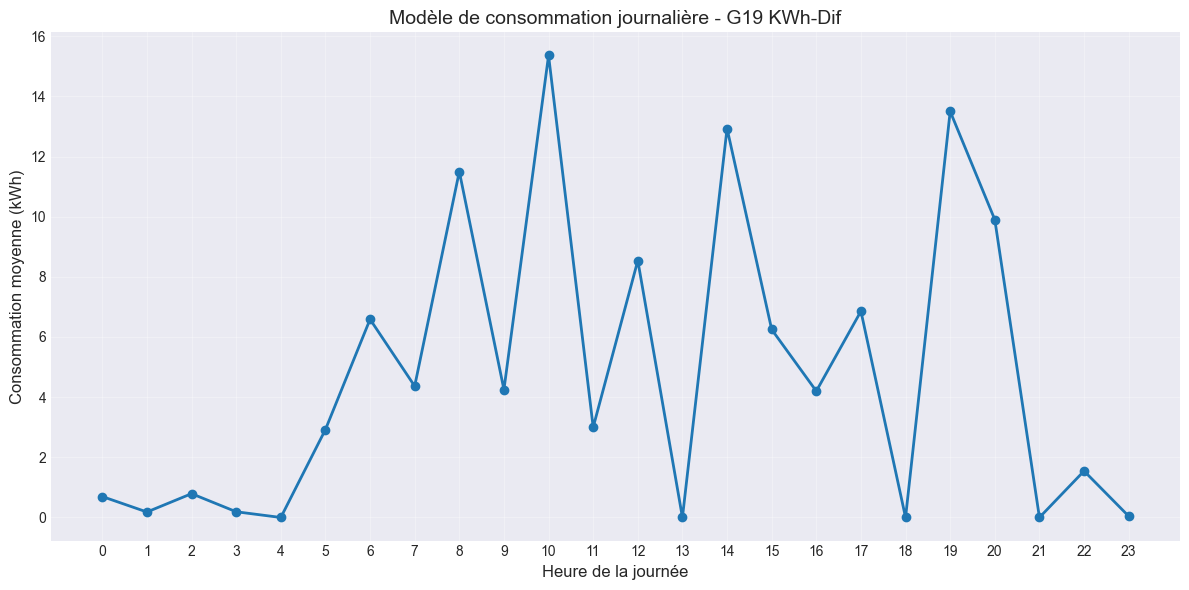

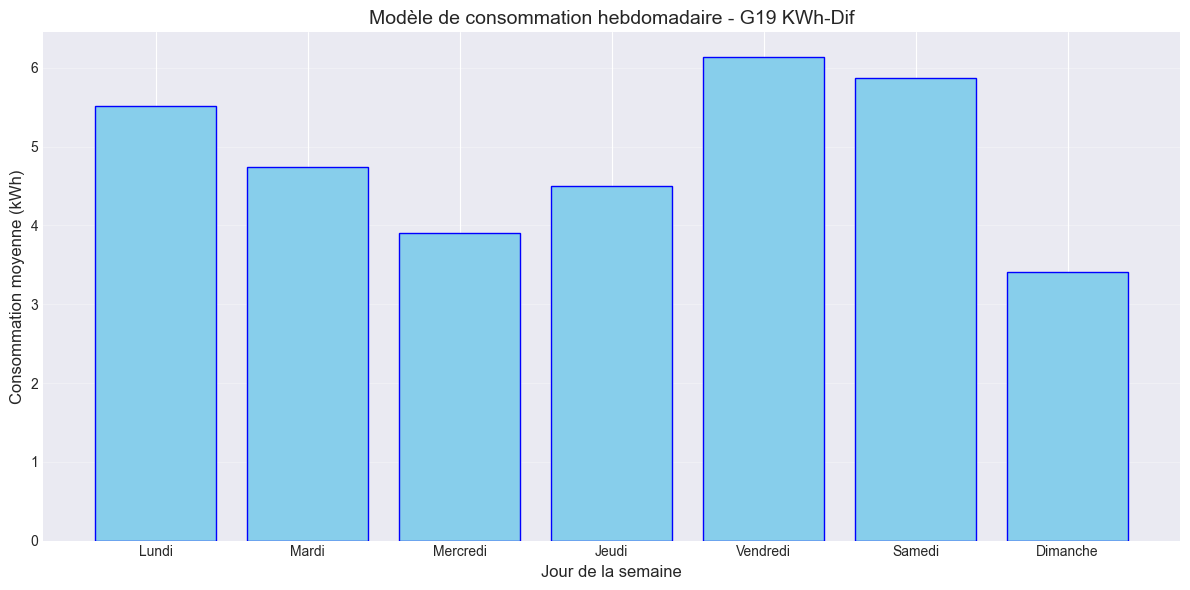

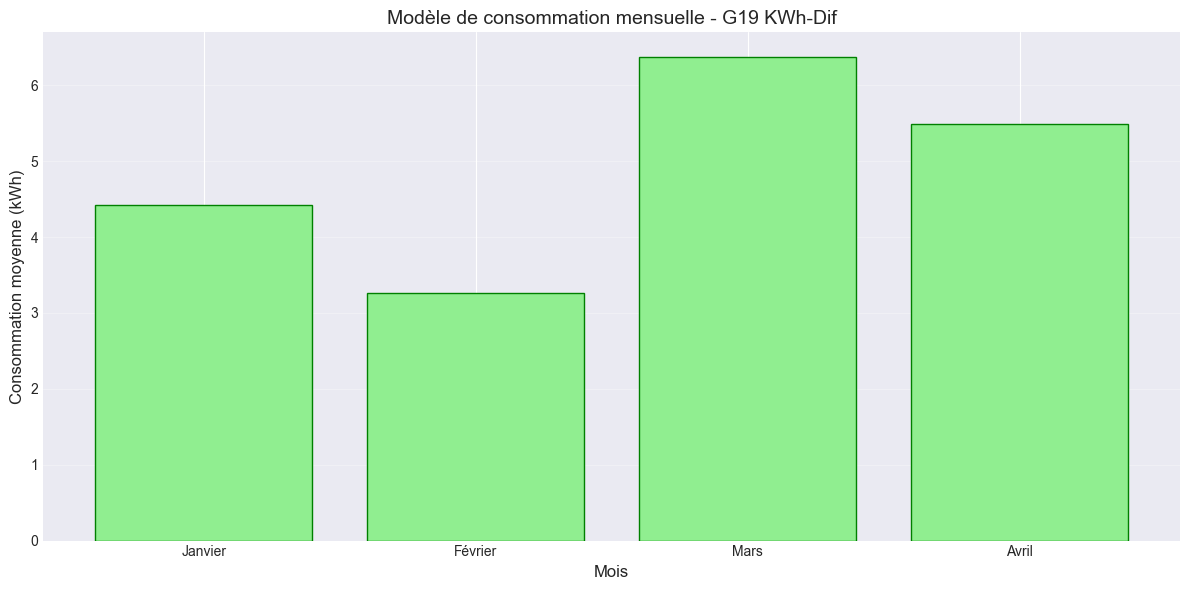

In [12]:
# Sélection d'une colonne pour la visualisation
# Vous pouvez modifier cette valeur pour visualiser d'autres capteurs
# selected_column is defined in the auto-generated fix cell
selected_column = selected_column

# Visualisations
plot_time_series(df_running, selected_column)
plot_daily_pattern(df_running, selected_column)
plot_weekly_pattern(df_running, selected_column)
plot_monthly_pattern(df_running, selected_column)

## 5. Modèles de prévision - Configuration

In [13]:
def prepare_data_for_forecasting(df, column, train_ratio=0.8):
    """Prépare les données pour la prévision."""
    data = df[column].copy()
    
    # Division en ensembles d'entraînement et de test
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    return train_data, test_data

def evaluate_forecast(actual, predicted):
    """Évalue les performances d'un modèle de prévision."""
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return mae, mse, rmse, mape

def plot_forecast_results(train_data, test_data, forecast, model_name):
    """Visualise les résultats de la prévision."""
    plt.figure(figsize=(15, 6))
    
    # Données d'entraînement
    plt.plot(train_data.index, train_data.values, label='Entraînement', color='blue')
    
    # Données de test
    plt.plot(test_data.index, test_data.values, label='Test', color='green')
    
    # Prévisions
    plt.plot(test_data.index, forecast, label='Prévision', color='red', linestyle='--')
    
    plt.title(f'Prévision avec {model_name}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Consommation', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 6. Modèle de prévision journalière

In [14]:
def daily_forecast(df, column, forecast_periods=24):
    """Effectue une prévision journalière pour une colonne donnée."""
    # Préparation des données
    train_data, test_data = prepare_data_for_forecasting(df, column)
    
    # Si les données de test sont trop courtes, ajuster les périodes de prévision
    if len(test_data) < forecast_periods:
        forecast_periods = len(test_data)
    
    # Modèle SARIMA pour la prévision journalière
    # Périodes saisonnières = 24 (heures dans une journée)
    try:
        print(f"\nPrévision journalière pour {column} avec SARIMA")
        model = SARIMAX(train_data, 
                         order=(1, 1, 1),
                         seasonal_order=(1, 1, 1, 24),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
        
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=forecast_periods)
        
        # Évaluation et visualisation
        actual_values = test_data[:forecast_periods].values
        predicted_values = forecast[:forecast_periods].values
        
        print("\nÉvaluation du modèle SARIMA journalier:")
        evaluate_forecast(actual_values, predicted_values)
        
        # Visualisation
        plot_forecast_results(train_data, test_data[:forecast_periods], 
                              forecast[:forecast_periods], "SARIMA (Journalier)")
        
        return model_fit, forecast
    
    except Exception as e:
        print(f"Erreur lors de la prévision journalière: {e}")
        
        # Essayer un modèle plus simple si SARIMA échoue
        try:
            print("\nEssai avec un modèle Holt-Winters (ExponentialSmoothing)")
            model = ExponentialSmoothing(train_data, 
                                         seasonal='add', 
                                         seasonal_periods=24)
            
            model_fit = model.fit()
            forecast = model_fit.forecast(forecast_periods)
            
            # Évaluation et visualisation
            actual_values = test_data[:forecast_periods].values
            predicted_values = forecast[:forecast_periods].values
            
            print("\nÉvaluation du modèle Holt-Winters journalier:")
            evaluate_forecast(actual_values, predicted_values)
            
            # Visualisation
            plot_forecast_results(train_data, test_data[:forecast_periods], 
                                 forecast[:forecast_periods], "Holt-Winters (Journalier)")
            
            return model_fit, forecast
        
        except Exception as e2:
            print(f"Erreur lors de la prévision avec Holt-Winters: {e2}")
            return None, None


Prévision journalière pour G19 KWh-Dif avec SARIMA

Évaluation du modèle SARIMA journalier:
MAE: 10.5006
MSE: 415.4134
RMSE: 20.3817
MAPE: inf%


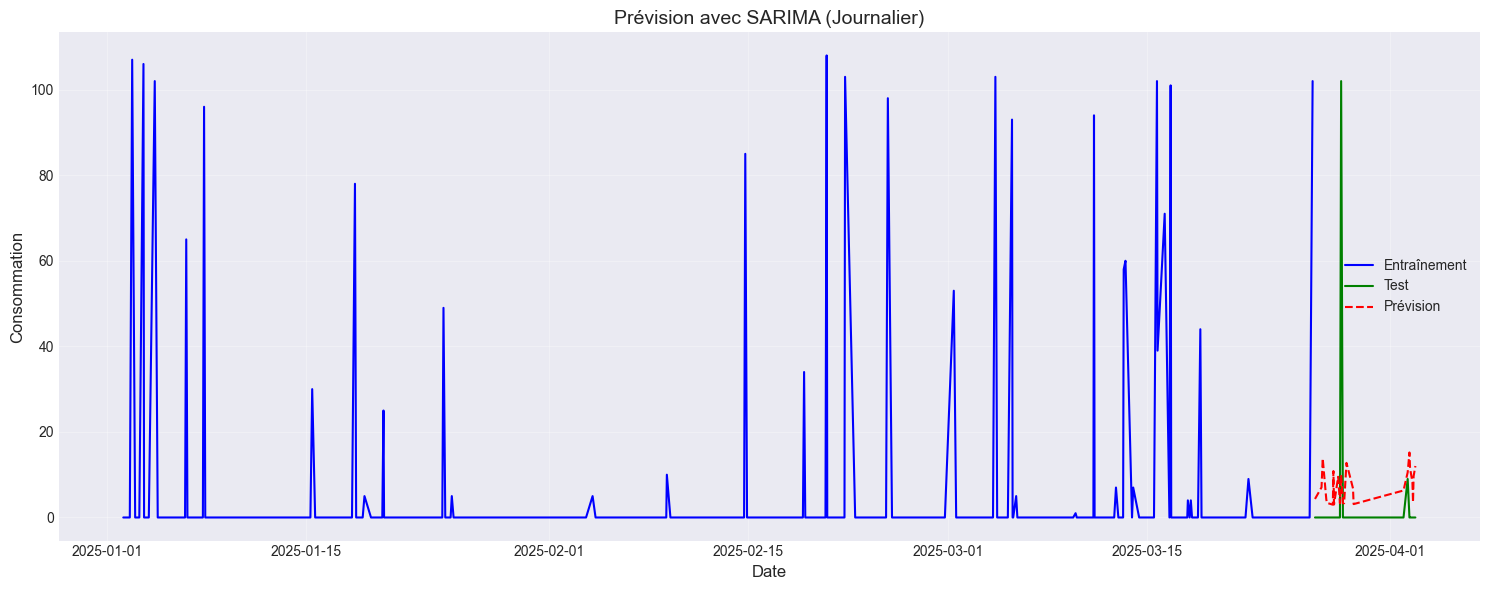

In [15]:
# Exécuter la prévision journalière
daily_model, daily_forecast_values = daily_forecast(df_running, selected_column)

## 7. Modèle de prévision hebdomadaire

In [16]:
def weekly_forecast(df, column, forecast_days=7):
    """Effectue une prevision hebdomadaire pour une colonne donnee."""
    print(f"\nPrévision hebdomadaire pour {column} avec Prophet")
    
    # Convertir les données en fréquence journalière en prenant la moyenne par jour
    daily_data = df[column].resample('D').mean()
    
    # Vérifier et traiter les valeurs NaN
    if daily_data.isna().any():
        print("Données manquantes détectées - Nettoyage des valeurs NaN...")
        # Supprimer les valeurs NaN (ou utiliser interpolation si préféré)
        daily_data = daily_data.dropna()
        if len(daily_data) == 0:
            print("Toutes les données sont des NaN. Impossible de continuer.")
            return None, None
    
    # Séparation entraînement/test
    train_size = int(len(daily_data) * 0.8)
    if train_size == 0:
        train_size = 1  # Au moins une donnée pour l'entraînement
    
    train_data = daily_data[:train_size]
    test_data = daily_data[train_size:]
    
    # Vérifier si les données d'entraînement sont suffisantes
    if len(train_data) < 2:
        print("Pas assez de données pour la prévision hebdomadaire")
        return None, None
    
    # Vérifier si les données de test sont suffisantes
    if len(test_data) < forecast_days:
        print("Attention: Données de test insuffisantes pour la période de prévision")
        forecast_days = max(1, len(test_data))
    
    try:
        # Préparation des données pour Prophet
        train_df = pd.DataFrame({
            'ds': train_data.index,
            'y': train_data.values
        })
        
        # Vérifier une dernière fois les valeurs NaN
        if train_df['y'].isna().any():
            train_df = train_df.dropna(subset=['y'])
            print("Valeurs NaN supprimées du jeu d'entraînement")
        
        if len(train_df) < 2:
            raise ValueError("Pas assez de données valides après nettoyage")
        
        # Modèle Prophet
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='multiplicative'
        )
        model.fit(train_df)
        
        # Création du dataframe pour la prévision
        future = model.make_future_dataframe(periods=forecast_days, freq='D')
        forecast = model.predict(future)
        
        # Extraction des prévisions pour la période de test
        forecast_values = forecast['yhat'][-forecast_days:].values
        
        # Vérifier les NaN dans les prévisions
        if np.isnan(forecast_values).any():
            print("Attention: Les prévisions contiennent des valeurs NaN.")
            # Remplacer les NaN par la moyenne ou la dernière valeur valide
            last_valid = np.nanmean(forecast_values) if not np.isnan(np.nanmean(forecast_values)) else 0
            forecast_values = np.nan_to_num(forecast_values, nan=last_valid)
        
        # Préparer les valeurs réelles pour l'évaluation
        actual_values = test_data[:forecast_days].values
        
        # Vérifier les NaN dans les valeurs réelles
        if np.isnan(actual_values).any():
            print("Attention: Les données de test contiennent des valeurs NaN.")
            # Créer un masque pour ignorer les NaN dans l'évaluation
            mask = ~np.isnan(actual_values)
            if np.any(mask):  # S'il reste des valeurs non-NaN
                print("\nÉvaluation du modèle Prophet hebdomadaire (valeurs non-NaN uniquement):")
                evaluate_forecast(actual_values[mask], forecast_values[mask])
            else:
                print("Impossible d'évaluer: toutes les valeurs de test sont NaN")
        else:
            print("\nÉvaluation du modèle Prophet hebdomadaire:")
            evaluate_forecast(actual_values, forecast_values)
        
        # Visualisation
        plt.figure(figsize=(15, 6))
        plt.plot(train_data.index, train_data.values, label='Entraînement', color='blue')
        
        # Utiliser un masque pour les valeurs réelles non-NaN
        if not np.isnan(actual_values).all():
            test_index = test_data[:forecast_days].index
            mask = ~np.isnan(actual_values)
            plt.plot(np.array(test_index)[mask], actual_values[mask], 
                    label='Test', color='green')
        
        plt.plot(test_data[:forecast_days].index, forecast_values, 
                label='Prévision', color='red', linestyle='--')
        
        plt.title(f'Prévision hebdomadaire avec Prophet - {column}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Consommation moyenne par jour', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Composantes de la prévision
        fig2 = model.plot_components(forecast)
        plt.show()
        
        return model, forecast
    
    except Exception as e:
        print(f"Erreur lors de la prévision hebdomadaire avec Prophet: {e}")
        
        # Alternative avec ARIMA
        try:
            print("\nEssai avec ARIMA pour la prévision hebdomadaire")
            
            # Vérifier encore les NaN pour ARIMA
            clean_train = train_data.dropna()
            if len(clean_train) < 2:
                raise ValueError("Pas assez de données sans NaN pour ARIMA")
            
            model = ARIMA(clean_train, order=(5, 1, 0))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=forecast_days)
            
            # Vérifier les NaN dans les prévisions ARIMA
            if np.isnan(forecast.values).any():
                print("Attention: Les prévisions ARIMA contiennent des valeurs NaN.")
                last_valid = np.nanmean(forecast.values) if not np.isnan(np.nanmean(forecast.values)) else 0
                forecast = pd.Series(np.nan_to_num(forecast.values, nan=last_valid), index=forecast.index)
            
            # Évaluation avec masque pour les NaN
            test_vals = test_data[:forecast_days].values
            if np.isnan(test_vals).any():
                mask = ~np.isnan(test_vals)
                if np.any(mask):
                    print("\nÉvaluation du modèle ARIMA hebdomadaire (valeurs non-NaN uniquement):")
                    evaluate_forecast(test_vals[mask], forecast.values[mask])
                else:
                    print("Impossible d'évaluer: toutes les valeurs de test sont NaN")
            else:
                print("\nÉvaluation du modèle ARIMA hebdomadaire:")
                evaluate_forecast(test_vals, forecast.values)
            
            # Visualisation
            plt.figure(figsize=(15, 6))
            plt.plot(clean_train.index, clean_train.values, label='Entraînement', color='blue')
            
            if not np.isnan(test_vals).all():
                test_index = test_data[:forecast_days].index
                mask = ~np.isnan(test_vals)
                plt.plot(np.array(test_index)[mask], test_vals[mask], 
                        label='Test', color='green')
            
            plt.plot(test_data[:forecast_days].index, forecast.values, 
                    label='Prévision (ARIMA)', color='red', linestyle='--')
            
            plt.title(f'Prévision hebdomadaire avec ARIMA - {column}', fontsize=14)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Consommation moyenne par jour', fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            return model_fit, forecast
        
        except Exception as e2:
            print(f"Erreur lors de la prévision hebdomadaire avec ARIMA: {e2}")
            return None, None

16:07:30 - cmdstanpy - INFO - Chain [1] start processing



Prévision hebdomadaire pour G19 KWh-Dif avec Prophet
Données manquantes détectées - Nettoyage des valeurs NaN...


16:07:30 - cmdstanpy - INFO - Chain [1] done processing



Évaluation du modèle Prophet hebdomadaire:
MAE: 53.8541
MSE: 3756.1738
RMSE: 61.2876
MAPE: inf%


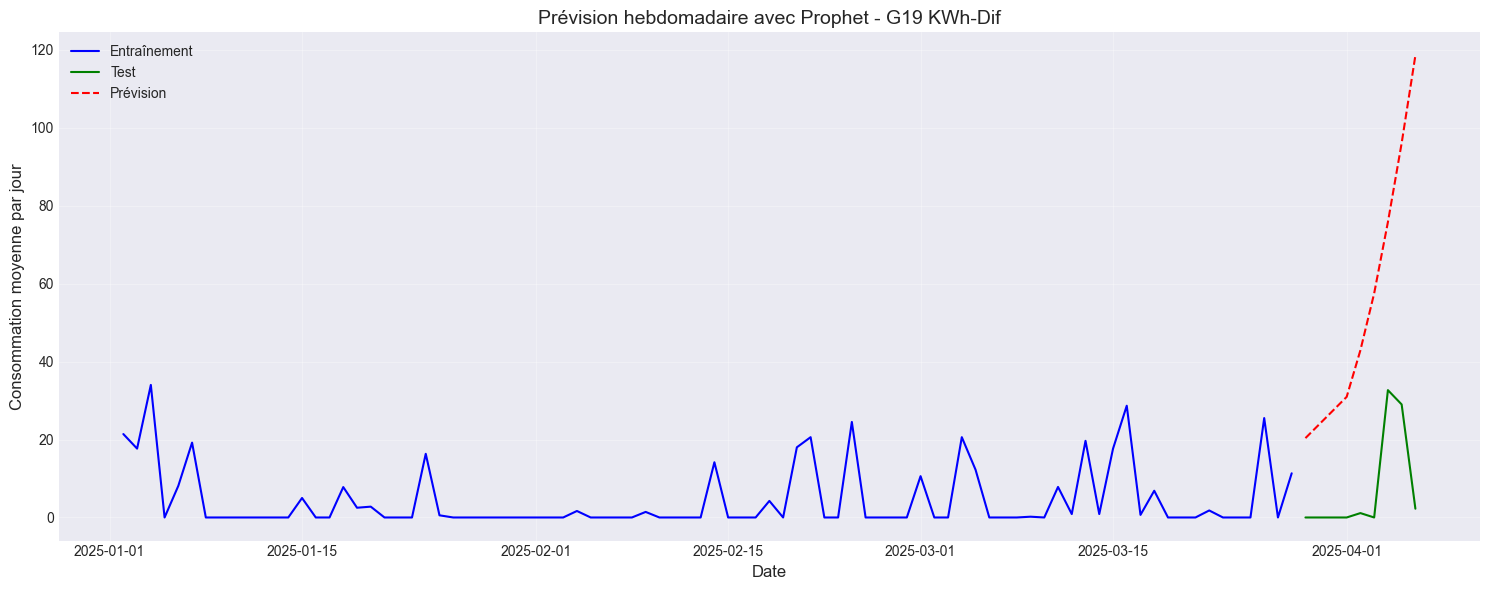

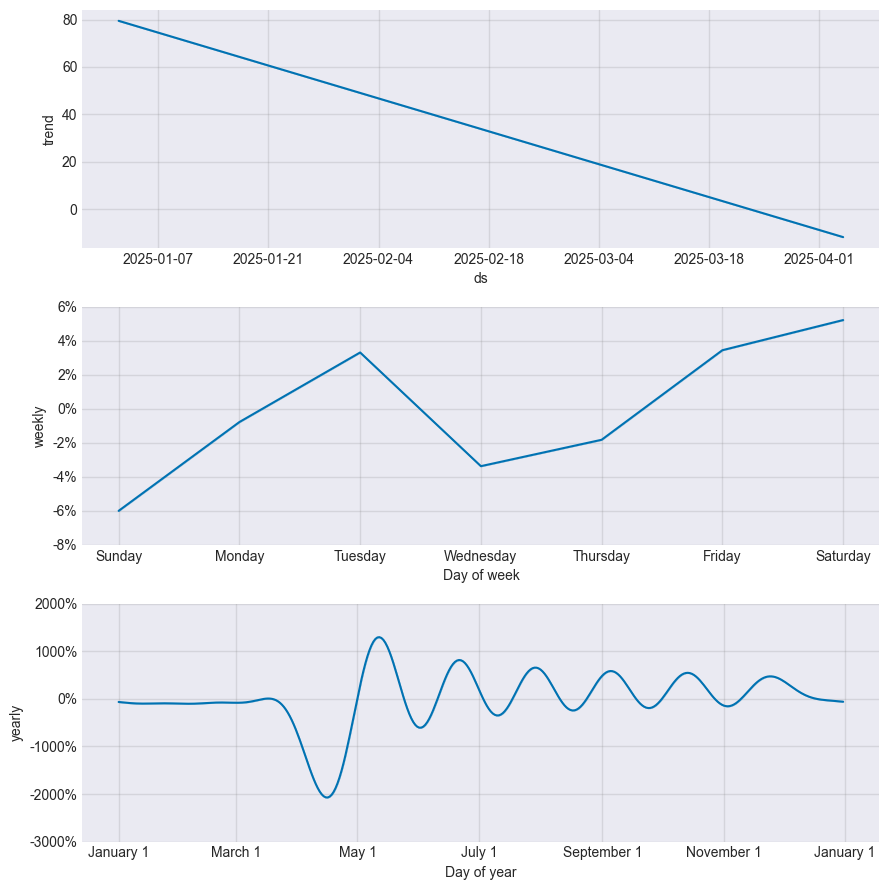

In [17]:
# Exécuter la prévision hebdomadaire
weekly_model, weekly_forecast_values = weekly_forecast(df_running, selected_column)

## 8. Modèle de prévision mensuelle

In [18]:
def monthly_forecast(df, column, forecast_months=1):
    """Effectue une prévision mensuelle pour une colonne donnée."""
    # Vérifier s'il y a suffisamment de données pour une prévision mensuelle
    if len(df.index.month.unique()) <= 1:
        print("Pas assez de données pour une prévision mensuelle (un seul mois disponible)")
        return None, None
    
    # Regrouper par mois pour avoir des données mensuelles
    monthly_data = df[column].resample('MS').mean()  # MS = Month Start
    
    # Si moins de 3 mois de données, impossible de faire une prévision mensuelle fiable
    if len(monthly_data) < 3:
        print("Pas assez de données mensuelles pour une prévision fiable (minimum 3 mois requis)")
        return None, None
    
    # Préparation des données
    train_size = max(1, int(len(monthly_data) * 0.8))  # Au moins 1 mois d'entraînement
    train_data = monthly_data[:train_size]
    test_data = monthly_data[train_size:]
    
    # Si pas de données de test, utiliser les derniers 20% pour le test
    if len(test_data) == 0:
        print("Utilisation d'une partie des données d'entraînement comme données de test")
        train_size = max(1, int(len(monthly_data) * 0.8))  # Au moins 1 mois d'entraînement
        train_data = monthly_data[:train_size]
        test_data = monthly_data[train_size:]
    
    # Si toujours pas assez de données, simuler la prévision sur le dernier mois
    if len(test_data) == 0:
        print("Simulation de la prévision sur le dernier mois disponible")
        test_data = pd.Series([monthly_data.iloc[-1]], index=[monthly_data.index[-1] + pd.DateOffset(months=1)])
    
    forecast_months = min(forecast_months, len(test_data))
    
    try:
        print(f"\nPrévision mensuelle pour {column} avec ExponentialSmoothing")
        
        # Vérifier s'il y a suffisamment de données pour la saisonnalité
        has_full_seasonality = len(monthly_data) >= 24  # Au moins 2 années complètes
        
        if has_full_seasonality:
            # Utiliser le modèle ExponentialSmoothing avec composante saisonnière
            model = ExponentialSmoothing(
                train_data, 
                trend='add', 
                seasonal='add', 
                seasonal_periods=12  # 12 mois dans une année
            )
            print("Utilisation du modèle avec saisonnalité (12 mois)")
        else:
            # Utiliser ExponentialSmoothing sans saisonnalité ou une alternative plus simple
            print("Données insuffisantes pour saisonnalité - utilisation du modèle sans saisonnalité")
            model = ExponentialSmoothing(
                train_data,
                trend='add',
                seasonal=None  # Désactiver la composante saisonnière
            )
        
        model_fit = model.fit()
        forecast = model_fit.forecast(forecast_months)
        
        # Évaluation si possible
        if len(test_data) >= forecast_months:
            print("\nÉvaluation du modèle ExponentialSmoothing mensuel:")
            evaluate_forecast(test_data[:forecast_months].values, forecast.values)
        else:
            print("Prévision effectuée, mais pas assez de données de test pour l'évaluation")
        
        # Visualisation
        plt.figure(figsize=(15, 6))
        plt.plot(train_data.index, train_data.values, label='Entraînement', color='blue')
        
        if len(test_data) >= forecast_months:
            plt.plot(test_data[:forecast_months].index, test_data[:forecast_months].values, 
                     label='Test', color='green')
        
        # Prévisions
        forecast_index = pd.date_range(start=train_data.index[-1] + pd.DateOffset(months=1), 
                                       periods=forecast_months, freq='MS')
        plt.plot(forecast_index, forecast.values, label='Prévision', color='red', linestyle='--')
        
        plt.title(f'Prévision mensuelle avec ExponentialSmoothing - {column}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Consommation moyenne par mois', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return model_fit, forecast
    
    except Exception as e:
        print(f"Erreur lors de la prévision mensuelle: {e}")
        
        # Alternative avec une méthode plus simple
        try:
            print("\nEssai avec une méthode de prévision plus simple (SES)")
            
            # Utiliser Simple Exponential Smoothing
            model = SimpleExpSmoothing(train_data)
            model_fit = model.fit()
            forecast = model_fit.forecast(forecast_months)
            
            # Visualisation
            plt.figure(figsize=(15, 6))
            plt.plot(train_data.index, train_data.values, label='Entraînement', color='blue')
            
            if len(test_data) >= forecast_months:
                plt.plot(test_data[:forecast_months].index, test_data[:forecast_months].values, 
                        label='Test', color='green')
                print("\nÉvaluation du modèle SES mensuel:")
                evaluate_forecast(test_data[:forecast_months].values, forecast.values)
            
            # Prévisions
            forecast_index = pd.date_range(start=train_data.index[-1] + pd.DateOffset(months=1), 
                                        periods=forecast_months, freq='MS')
            plt.plot(forecast_index, forecast.values, label='Prévision (SES)', color='red', linestyle='--')
            
            plt.title(f'Prévision mensuelle avec Simple Exponential Smoothing - {column}', fontsize=14)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Consommation moyenne par mois', fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            return model_fit, forecast
            
        except Exception as e2:
            print(f"Erreur lors de la méthode alternative: {e2}")
            
            # Dernière alternative: prévision naïve (dernière valeur)
            print("\nUtilisation d'une prévision naïve (dernière valeur connue)")
            last_value = train_data.iloc[-1]
            forecast_index = pd.date_range(start=train_data.index[-1] + pd.DateOffset(months=1), 
                                      periods=forecast_months, freq='MS')
            forecast = pd.Series([last_value] * forecast_months, index=forecast_index)
            
            # Visualisation
            plt.figure(figsize=(15, 6))
            plt.plot(train_data.index, train_data.values, label='Entraînement', color='blue')
            
            if len(test_data) >= forecast_months:
                plt.plot(test_data[:forecast_months].index, test_data[:forecast_months].values, 
                        label='Test', color='green')
                print("\nÉvaluation de la prévision naïve mensuelle:")
                evaluate_forecast(test_data[:forecast_months].values, forecast.values)
            
            plt.plot(forecast_index, forecast.values, label='Prévision (Naïve)', color='red', linestyle='--')
            
            plt.title(f'Prévision mensuelle naïve - {column}', fontsize=14)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Consommation moyenne par mois', fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            return None, forecast


Prévision mensuelle pour G19 KWh-Dif avec ExponentialSmoothing
Données insuffisantes pour saisonnalité - utilisation du modèle sans saisonnalité

Évaluation du modèle ExponentialSmoothing mensuel:
MAE: 1.1530
MSE: 1.3293
RMSE: 1.1530
MAPE: 21.00%


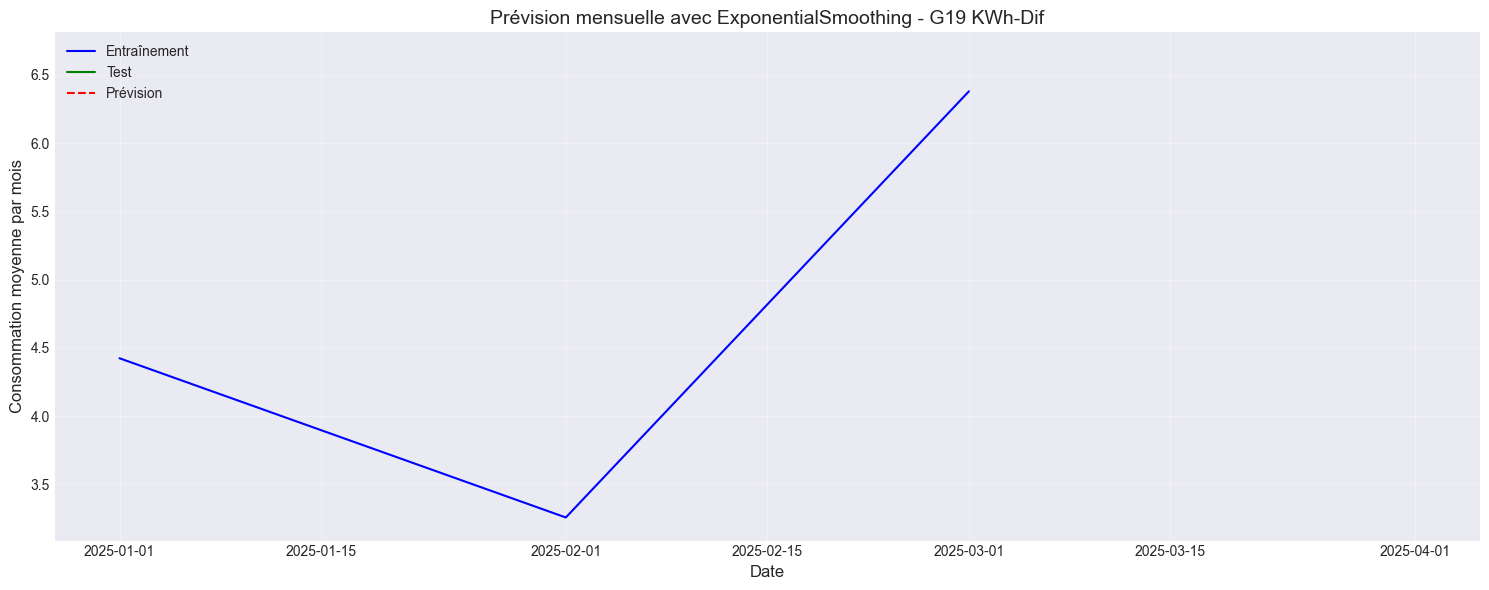

In [19]:
# Exécuter la prévision mensuelle
monthly_model, monthly_forecast_values = monthly_forecast(df_running, selected_column)

## 9. Détection d'anomalies dans les données

In [20]:
def detect_anomalies_isolation_forest(df, columns=None, contamination=0.05):
    """
    Détecte les anomalies dans les données en utilisant l'algorithme Isolation Forest.
    
    Args:
        df: DataFrame contenant les données
        columns: Liste des colonnes à analyser (si None, toutes les colonnes numériques sont utilisées)
        contamination: Proportion attendue d'anomalies (par défaut 5%)
        
    Returns:
        DataFrame contenant uniquement les lignes avec des anomalies
    """
    # Sélection des colonnes
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Préparation des données
    X = df[columns].copy()
    
    # Normalisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Modèle Isolation Forest
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(X_scaled)
    
    # Prédiction (-1 pour anomalie, 1 pour normal)
    predictions = model.predict(X_scaled)
    anomaly_mask = predictions == -1
    
    # Création du dataframe résultat
    anomalies = df.loc[anomaly_mask].copy()
    
    print(f"Nombre d'anomalies détectées: {anomalies.shape[0]} sur {df.shape[0]} lignes ({(anomalies.shape[0]/df.shape[0])*100:.2f}%)")
    
    return anomalies, model

def detect_anomalies_statistical(df, columns=None, threshold=3.0):
    """
    Détecte les anomalies en utilisant la méthode statistique des Z-scores
    (valeurs s'écartant de plus de threshold écarts-types de la moyenne).
    
    Args:
        df: DataFrame contenant les données
        columns: Liste des colonnes à analyser (si None, toutes les colonnes numériques sont utilisées)
        threshold: Seuil en nombre d'écarts-types (par défaut 3.0)
        
    Returns:
        DataFrame contenant uniquement les lignes avec des anomalies
    """
    # Sélection des colonnes
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Calcul des Z-scores pour chaque colonne
    z_scores = pd.DataFrame()
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        # Éviter division par zéro
        if std > 0:
            z_scores[col] = (df[col] - mean) / std
        else:
            z_scores[col] = 0
    
    # Identification des anomalies (valeurs au-delà du seuil)
    anomaly_mask = (z_scores.abs() > threshold).any(axis=1)
    anomalies = df.loc[anomaly_mask].copy()
    
    print(f"Nombre d'anomalies statistiques détectées: {anomalies.shape[0]} sur {df.shape[0]} lignes ({(anomalies.shape[0]/df.shape[0])*100:.2f}%)")
    
    return anomalies

def plot_anomalies(df, anomalies, column, title=None):
    """
    Visualise les anomalies dans une série temporelle.
    """
    plt.figure(figsize=(15, 6))
    
    # Tracer toutes les données
    plt.plot(df.index, df[column], label='Données normales', color='blue', alpha=0.5)
    
    # Mettre en évidence les anomalies
    if not anomalies.empty:
        plt.scatter(anomalies.index, anomalies[column], color='red', label='Anomalies', s=50)
    
    plt.title(title or f'Détection d\'anomalies - {column}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Valeur', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Nombre d'anomalies détectées: 28 sur 547 lignes (5.12%)


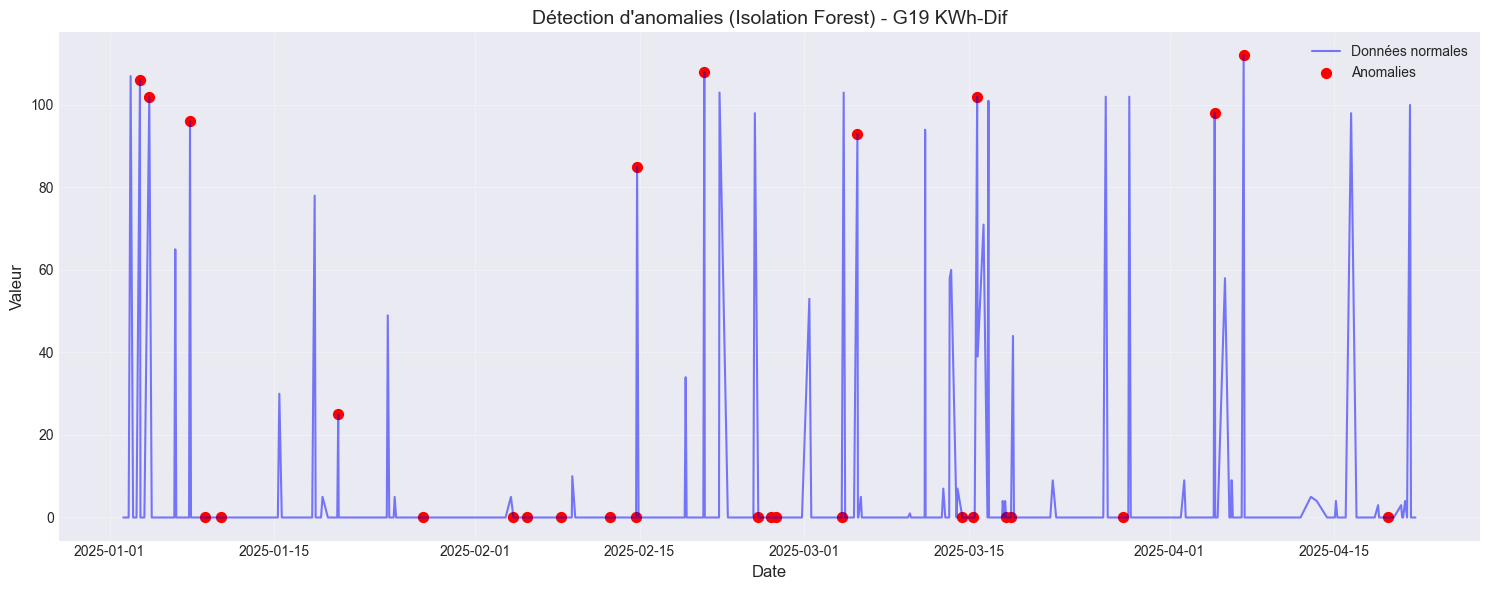

Nombre d'anomalies statistiques détectées: 100 sur 547 lignes (18.28%)


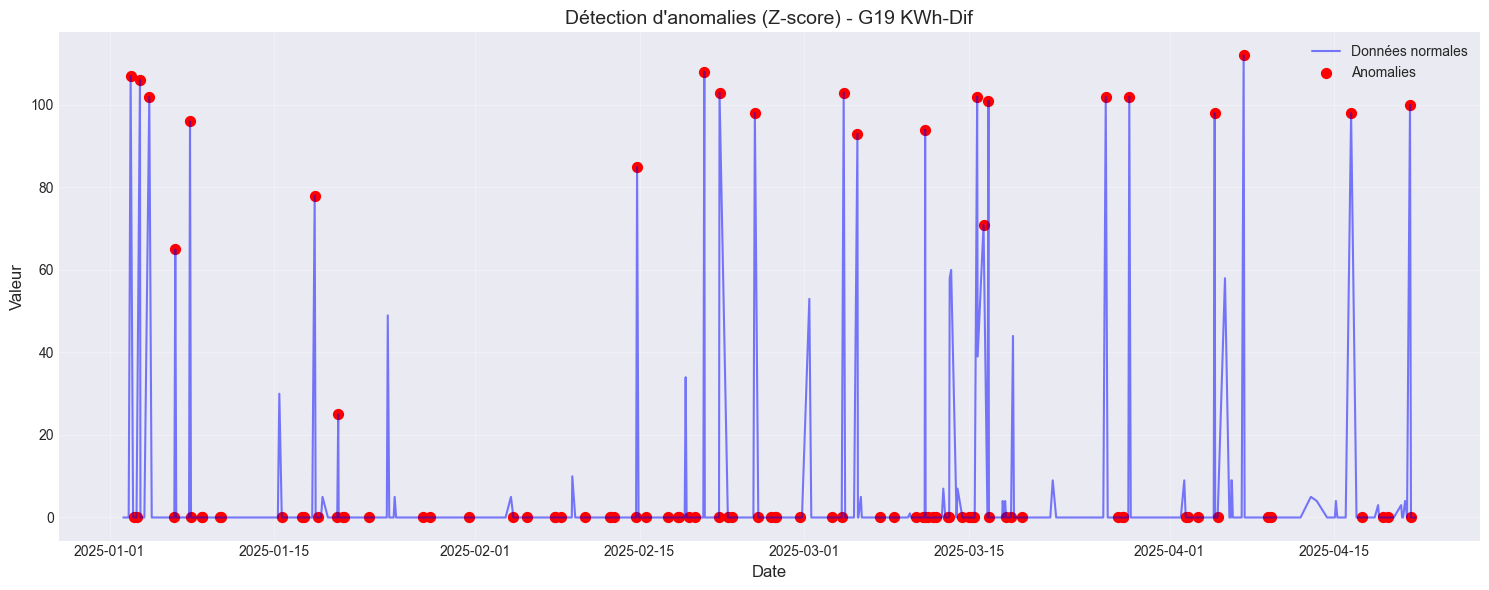

In [21]:
# Détection d'anomalies avec Isolation Forest
anomalies_if, model_if = detect_anomalies_isolation_forest(df_running)

# Visualisation des anomalies pour la colonne sélectionnée
plot_anomalies(df_running, anomalies_if, selected_column, 
               title=f'Détection d\'anomalies (Isolation Forest) - {selected_column}')

# Détection d'anomalies avec méthode statistique (Z-score)
anomalies_stat = detect_anomalies_statistical(df_running)

# Visualisation des anomalies statistiques
plot_anomalies(df_running, anomalies_stat, selected_column, 
               title=f'Détection d\'anomalies (Z-score) - {selected_column}')

## 10. Détection de machines arrêtées

In [22]:
def detect_stopped_machines(df, columns=None, consecutive_hours=4):
    """
    Détecte les machines qui sont arrêtées pendant au moins consecutive_hours heures consécutives.
    
    Args:
        df: DataFrame contenant les données temporelles
        columns: Liste des colonnes (machines) à surveiller (si None, toutes les colonnes numériques sont utilisées)
        consecutive_hours: Nombre d'heures consécutives pour considérer une machine comme arrêtée
        
    Returns:
        DataFrame avec les périodes d'arrêt par machine
    """
    if columns is None:
        # Exclure les colonnes temporelles
        time_cols = ['hour', 'day', 'weekday', 'week', 'month']
        columns = [col for col in df.columns if col not in time_cols]
    
    results = []
    
    for col in columns:
        # Considérer une machine comme arrêtée si sa consommation est nulle
        stopped = df[col] == 0.0
        
        # Trouver les séquences d'arrêt consécutives
        current_start = None
        consecutive_count = 0
        
        for idx, value in stopped.items():
            if value:  # Machine arrêtée
                if current_start is None:
                    current_start = idx
                consecutive_count += 1
            else:  # Machine en marche
                if consecutive_count >= consecutive_hours and current_start is not None:
                    # Enregistrer la période d'arrêt
                    results.append({
                        'Machine': col,
                        'Start': current_start,
                        'End': idx,
                        'Hours': consecutive_count
                    })
                current_start = None
                consecutive_count = 0
        
        # Gérer le cas où la machine est arrêtée à la fin de la série
        if consecutive_count >= consecutive_hours and current_start is not None:
            results.append({
                'Machine': col,
                'Start': current_start,
                'End': stopped.index[-1],
                'Hours': consecutive_count
            })
    
    # Créer le dataframe de résultats
    if results:
        result_df = pd.DataFrame(results)
        result_df = result_df.sort_values(['Machine', 'Start'])
        return result_df
    else:
        print("Aucune machine arrêtée pendant plus de", consecutive_hours, "heures consécutives")
        return pd.DataFrame(columns=['Machine', 'Start', 'End', 'Hours'])

In [23]:
# Analyse des arrêts de machines
stop_periods = detect_stopped_machines(df, consecutive_hours=5)

if not stop_periods.empty:
    print("\nPériodes d'arrêt des machines (plus de 5 heures consécutives):")
    display(stop_periods)
    
    # Exemple d'envoi d'email (à décommenter et configurer si nécessaire)
    """
    # Configuration de l'email
    sender_email = "votre_email@gmail.com"
    sender_password = "votre_mot_de_passe"  # Utiliser un mot de passe d'application pour Gmail
    receiver_email = "destinataire@example.com"
    
    # Envoyer des alertes pour chaque arrêt de machine
    for idx, row in stop_periods.iterrows():
        envoyer_mail_arret_machine(
            machine_name=row['Machine'], 
            start_time=row['Start'], 
            hours_stopped=row['Hours'],
            sender_email=sender_email,
            sender_password=sender_password,
            receiver_email=receiver_email
        )
    """
else:
    print("Aucune période d'arrêt détectée")


Périodes d'arrêt des machines (plus de 5 heures consécutives):


,Machine,Start,End,Hours
0,G19 KWh-Dif,2025-01-01 00:00:00,2025-01-02 19:00:00,43
1,G19 KWh-Dif,2025-01-02 20:00:00,2025-01-03 14:00:00,18
2,G19 KWh-Dif,2025-01-03 15:00:00,2025-01-04 09:00:00,18
3,G19 KWh-Dif,2025-01-04 10:00:00,2025-01-06 14:00:00,52
4,G19 KWh-Dif,2025-01-06 15:00:00,2025-01-07 20:00:00,29
...,...,...,...,...
386,MISFAT 3 N11 KWh-Dif,2025-03-19 13:00:00,2025-04-02 10:00:00,333
387,MISFAT 3 N11 KWh-Dif,2025-04-02 11:00:00,2025-04-07 09:00:00,111
388,MISFAT 3 N11 KWh-Dif,2025-04-07 10:00:00,2025-04-09 08:00:00,46
389,MISFAT 3 N11 KWh-Dif,2025-04-09 09:00:00,2025-04-21 12:00:00,288


## 11. Tableau de bord récapitulatif

In [24]:
def create_dashboard(df, selected_columns=None, n_columns=3):
    """
    Crée un tableau de bord visuel pour les colonnes sélectionnées.
    """
    if selected_columns is None:
        # Exclure les colonnes à valeur constante (zéro)
        cols_all_zero = df.apply(lambda col: (col == 0.0).all(), axis=0)
        selected_columns = [col for col in df.columns if not cols_all_zero[col]]
    
    n_plots = len(selected_columns)
    n_rows = (n_plots + n_columns - 1) // n_columns
    
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 4 * n_rows))
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    for i, col in enumerate(selected_columns):
        if i < len(axes):
            # Graphique principal
            df[col].plot(ax=axes[i], title=f'Série temporelle : {col}', legend=False, color='blue')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel('Valeur')
            axes[i].grid(True, alpha=0.3)
            
            # Statistiques
            mean_val = df[col].mean()
            std_val = df[col].std()
            max_val = df[col].max()
            
            # Ajouter une ligne horizontale pour la moyenne
            axes[i].axhline(y=mean_val, color='r', linestyle='-', alpha=0.3)
            
            # Ajouter un texte informatif
            stats_text = f'Moy: {mean_val:.2f}, Std: {std_val:.2f}, Max: {max_val:.2f}'
            axes[i].text(0.05, 0.95, stats_text, transform=axes[i].transAxes, 
                         fontsize=8, verticalalignment='top', 
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Masquer les axes inutilisés
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

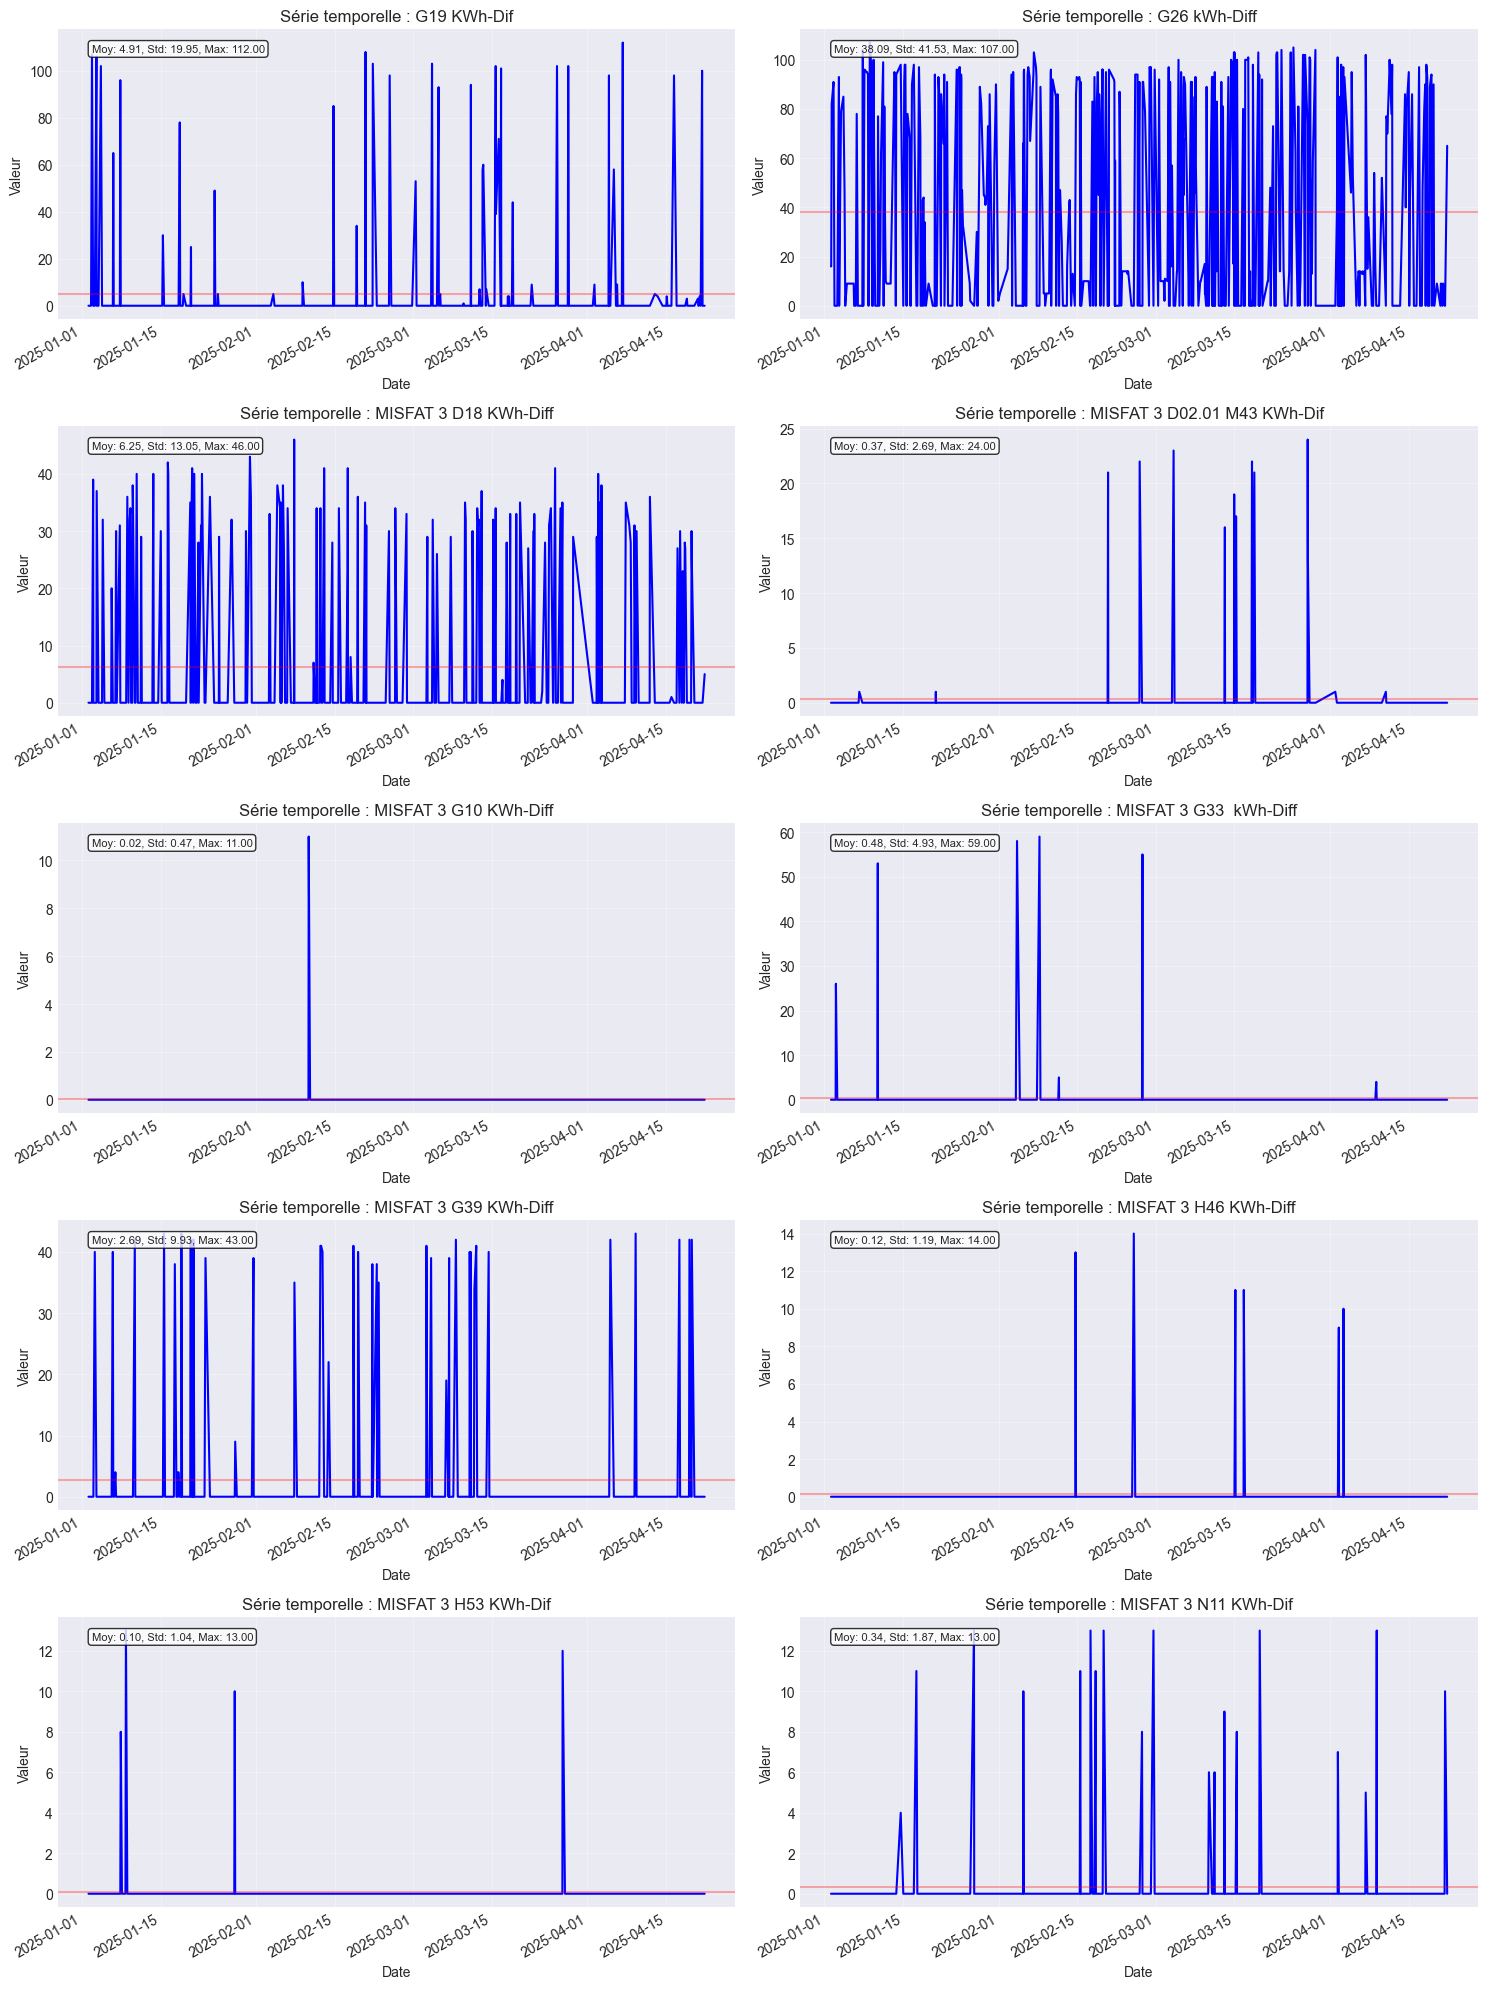

In [25]:
# Création du tableau de bord récapitulatif
create_dashboard(df_running, n_columns=2)

## 12. Conclusion et recommandations

Ce notebook a permis d'analyser les données de consommation électrique des équipements MISFAT et de mettre en place des modèles de prévision pour différentes échelles temporelles:

1. **Prévision journalière**: Utilise SARIMA ou Holt-Winters pour prévoir la consommation heure par heure
2. **Prévision hebdomadaire**: Utilise Prophet ou ARIMA pour prévoir la consommation quotidienne sur une semaine
3. **Prévision mensuelle**: Utilise ExponentialSmoothing pour prévoir la consommation mensuelle

De plus, des mécanismes de détection d'anomalies ont été mis en place:
- Détection d'anomalies par Isolation Forest
- Détection d'anomalies par approche statistique (Z-score)
- Détection des machines arrêtées pendant des périodes prolongées

### Recommandations

1. **Automatisation**: Mettre en place un système automatisé pour exécuter ces analyses régulièrement
2. **Alertes**: Configurer les alertes email pour les anomalies et les arrêts machine
3. **Optimisation**: Ajuster les paramètres des modèles en fonction des résultats observés
4. **Intégration**: Intégrer ces analyses dans un tableau de bord en temps réel pour les opérateurs
5. **Expansion**: Étendre l'analyse à d'autres équipements et sites de production

### Maintenance du modèle

Pour assurer la pertinence continue des prévisions:
- Réentraîner les modèles régulièrement avec les nouvelles données
- Ajuster les seuils de détection d'anomalies en fonction des faux positifs/négatifs observés
- Comparer différents algorithmes de prévision pour identifier le plus performant pour chaque équipement